# Graduation Project


## What is MURA?

MURA (musculoskeletal radiographs) is a large dataset of bone X-rays. Algorithms are tasked with determining whether an X-ray study is normal or abnormal.

Musculoskeletal conditions affect more than 1.7 billion people worldwide, and are the most common cause of severe, long-term pain and disability, with 30 million emergency department visits annually and increasing. We hope that our dataset can lead to significant advances in medical imaging technologies which can diagnose at the level of experts, towards improving healthcare access in parts of the world where access to skilled radiologists is limited.

MURA is one of the largest public radiographic image datasets. We're making this dataset available to the community and hosting a competition to see if your models can perform as well as radiologists on the task.

## Initialisation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.widgets import *
import shutil

In [3]:
from fastai.callbacks import * 

In [4]:
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.52
cuda: True


In [5]:
import gc
import torch

In [6]:
pwd

'/home/hussamwahba/Desktop/final111'

!wget 'https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip'

import zipfile
zip_ref = zipfile.ZipFile('/home/jupyter/MURA-v1.1.zip', 'r')
zip_ref.extractall('/home/jupyter/MURA')
zip_ref.close()

## Data

### Data path

In [ ]:
Config.DEFAULT_CONFIG = {
        'data_path': '/home/jupyter'
       
    }

Config.create('/tmp/myconfig.yml')
Config.DEFAULT_CONFIG_PATH = '/tmp/myconfig.yml'
Config.data_path()

In [6]:
path = Config.data_path() / 'MURA-v1.1'
path.ls()

[PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/results_224.csv'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/results_densenet161_112.csv'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/results_densenet161_224.csv'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/train_image_paths.csv'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/models'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/0'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/valid'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/data2'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/train'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/test.csv'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/results_resnet152_224.csv'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/results_vgg16_112.csv'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/export.pkl'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/results_resnet152_2242.csv'),


### csv

In [7]:
df_train = pd.read_csv(path / 'train_image_paths.csv', header=None, names=['image'])
df_train.image[0]

'MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png'

In [8]:
df_valid = pd.read_csv(path / 'valid_image_paths.csv', header=None, names=['image'])
df_valid.image[0]

'MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png'

In [9]:
df_train_label = pd.read_csv(path / 'train_labeled_studies.csv', header=None, names=['image', 'label'])
df_train_label.head()

,image,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


### Create folder data2 to train models

In [10]:
# Create data2 with data to train our models
path_train = path / 'data2/train'
path_valid = path / 'data2/valid'
path_train.mkdir(parents=True, exist_ok=True)
path_valid.mkdir(parents=True, exist_ok=True)

In [11]:
path_train_neg = path_train / '0'
path_train_pos = path_train / '1'
path_train_neg.mkdir(parents=True, exist_ok=True)
path_train_pos.mkdir(parents=True, exist_ok=True)

path_valid_neg = path_valid / '0'
path_valid_pos = path_valid / '1'
path_valid_neg.mkdir(parents=True, exist_ok=True)
path_valid_pos.mkdir(parents=True, exist_ok=True)

### Get list of images

In [12]:
fnames_train = get_image_files(path/'train', recurse=True)
print(len(fnames_train))
fnames_train[:5]

36808


[PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/train/XR_HUMERUS/patient03028/study1_negative/image1.png'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/train/XR_HUMERUS/patient03028/study1_negative/image2.png'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/train/XR_HUMERUS/patient02840/study1_positive/image1.png'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/train/XR_HUMERUS/patient02840/study1_positive/image2.png'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/train/XR_HUMERUS/patient02905/study1_positive/image1.png')]

In [13]:
fnames_valid = get_image_files(path/'valid', recurse=True)
print(len(fnames_valid))
fnames_valid[:5]

3197


[PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/valid/XR_HUMERUS/patient11697/study1_negative/image1.png'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/valid/XR_HUMERUS/patient11697/study1_negative/image2.png'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/valid/XR_HUMERUS/patient11637/study1_positive/image1.png'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/valid/XR_HUMERUS/patient11637/study1_positive/image2.png'),
 PosixPath('/home/hussamwahba/.fastai/data/MURA-v1.1/valid/XR_HUMERUS/patient11679/study1_negative/image1.png')]

### Copy images into data2

In [14]:
pat_label = re.compile(r'/XR_([^/]+)/[^/]+/[^/]+/[^/]+.png$')
pat_patient = re.compile(r'/[^/]+/patient([^/]+)/[^/]+/[^/]+.png$')
pat_study = re.compile(r'/[^/]+/[^/]+/([^/]+)/[^/]+.png$')
# pat_study_negpos = re.compile(r'\\[^\\]+\\[^\\]+\\study\d+_([^\\]+)\\[^\\]+.png$')

In [ ]:
%%time
# copy all train images in corresponding class folders under MURA-v1.1/data2/train
for src in fnames_train:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)  
    # create class folder if necessary
    if 'negative' in study:
        path_label = path_train_neg
    else:
        path_label = path_train_pos
    # copy image to its class folder
    img_name = label + '_patient' + patient + '_' + study + '_' + src.name
    dest = path_label / img_name
    shutil.copy(str(src), str(dest))

In [ ]:
%%time
# copy all valid images in corresponding class folders under MURA-v1.1/data2/valid
for src in fnames_valid:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)  
    # create class folder if necessary
    if 'negative' in study:
        path_label = path_valid_neg
    else:
        path_label = path_valid_pos
    # copy image to its class folder
    img_name = label + '_patient' + patient + '_' + study + '_' + src.name
    dest = path_label / img_name
    shutil.copy(str(src), str(dest))

### Number of studies 

In [15]:
pat_label = re.compile(r'/XR_([^/]+)/[^/]+/[^/]+/[^/]+.png$')
pat_patient = re.compile(r'/[^/]+/patient([^/]+)/[^/]+/[^/]+.png$')
pat_study = re.compile(r'/([^/]+)_[^/]+/[^/]+.png$')

In [16]:
mura = ['elbow', 'finger', 'forearm', 'hand', 'humerus', 'shoulder', 'wrist']

study_train_dict = dict()
study_valid_dict = dict()

for m in mura:
    study_train_dict[m] = list()
    study_valid_dict[m] = list()
    
for src in fnames_train:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)
    # add to label list
    s = 'patient' + patient + '_' + study
    study_train_dict[label.lower()].append(s)

for src in fnames_valid:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)
    # add to label list
    s = 'patient' + patient + '_' + study
    study_valid_dict[label.lower()].append(s)

In [17]:
num_train_studies = 0
num_valid_studies = 0

for m in mura:
    # train
    myset = set(study_train_dict[m])
    num_train_studies += len(myset)
    # valid
    myset = set(study_valid_dict[m])
    num_valid_studies += len(myset)

In [18]:
# 207 studies in test
num_train_studies, num_valid_studies, num_train_studies + num_valid_studies + 207

(13457, 1199, 14863)

## Training with densenet161 

In [19]:
learn = None
gc.collect()

0

In [20]:
torch.cuda.empty_cache()

In [9]:
size = 224
bs = 16

np.random.seed(42)
data = ImageDataBunch.from_folder(path/'data2', ds_tfms=get_transforms(max_rotate = 30.0 ,max_warp = 0. , max_lighting=0.), 
                                  size=size, bs=bs
                                  ).normalize(imagenet_stats)

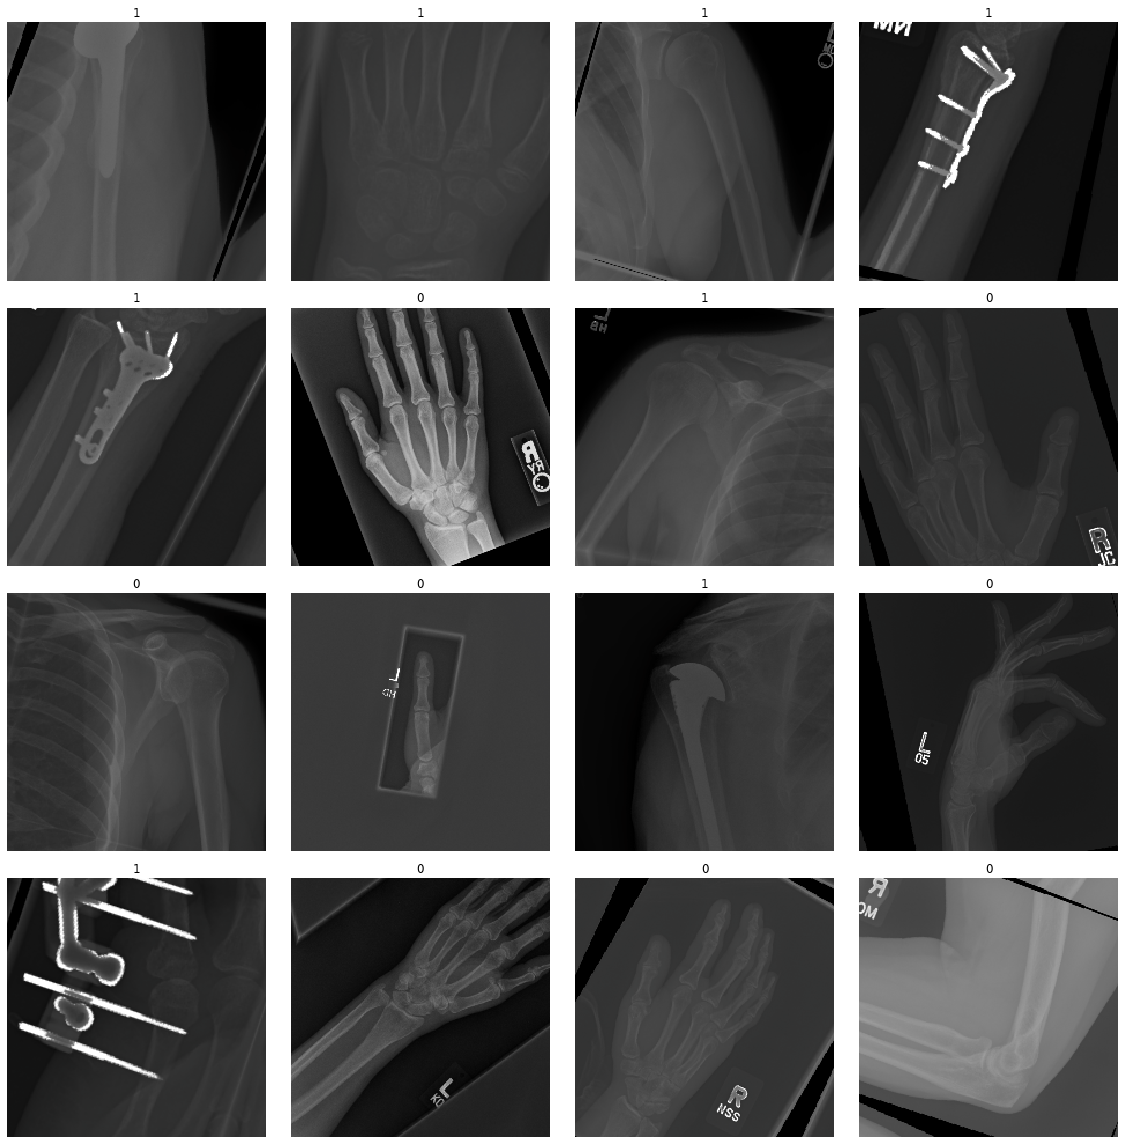

In [22]:
data.show_batch()

In [25]:
kappa = KappaScore()
kappa.weights = "quadratic"

In [26]:
learn = cnn_learner(data, models.densenet161, metrics=[error_rate, accuracy, kappa],wd=0.1).to_fp16()

/home/hussamwahba/anaconda3/envs/tfbones/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [25]:
learn.wd

0.1

In [26]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


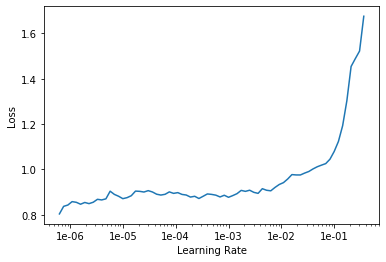

In [28]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,kappa_score,time
0,0.762542,0.607856,0.332186,0.667814,0.332109,31:15
1,0.692769,0.556416,0.276822,0.723178,0.443829,31:08
2,0.622087,0.530414,0.256178,0.743822,0.483665,31:09
3,0.587141,0.516732,0.243666,0.756334,0.508538,31:11
4,0.578077,0.516202,0.241789,0.758211,0.510921,31:14
5,0.523408,0.495189,0.226462,0.773538,0.542581,31:26
6,0.522365,0.489857,0.229277,0.770723,0.535373,31:26
7,0.485714,0.474987,0.219894,0.780106,0.555018,31:26
8,0.481406,0.448067,0.199249,0.800751,0.597536,31:24
9,0.461714,0.446192,0.200500,0.799500,0.594218,31:26


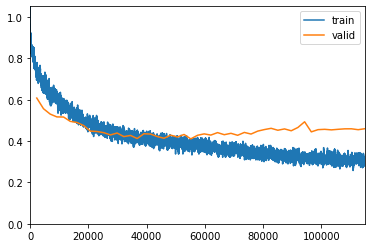

Better model found at epoch 0 with val_loss value: 0.6078561544418335.


/home/hussamwahba/anaconda3/envs/tfbones/lib/python3.6/site-packages/fastai/callbacks/tracker.py:50: UserWarning: <class 'fastai.callbacks.tracker.EarlyStoppingCallback'> conditioned on metric `valid_loss` which is not available. Available metrics are: train_loss, valid_loss, error_rate, accuracy, kappa_score, time
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')


Better model found at epoch 1 with val_loss value: 0.5564163327217102.
Better model found at epoch 2 with val_loss value: 0.5304137468338013.
Better model found at epoch 3 with val_loss value: 0.5167315602302551.
Better model found at epoch 4 with val_loss value: 0.5162020325660706.
Better model found at epoch 5 with val_loss value: 0.4951894283294678.
Better model found at epoch 6 with val_loss value: 0.4898569881916046.
Better model found at epoch 7 with val_loss value: 0.4749872386455536.
Better model found at epoch 8 with val_loss value: 0.448067307472229.
Better model found at epoch 9 with val_loss value: 0.4461919963359833.
Better model found at epoch 10 with val_loss value: 0.44058334827423096.
Better model found at epoch 11 with val_loss value: 0.42953842878341675.
Better model found at epoch 13 with val_loss value: 0.4215354025363922.
Better model found at epoch 15 with val_loss value: 0.4121145009994507.
Better model found at epoch 23 with val_loss value: 0.4104597568511963.


In [29]:
lr = 1e-4
learn.fit_one_cycle(50 ,max_lr=lr,callbacks=[ShowGraph(learn),EarlyStoppingCallback(learn, monitor='valid_loss', mode='min', min_delta=0.0003, patience=5),SaveModelCallback(learn ,monitor='val_loss',  mode='min')])

In [30]:
learn.save('densenet161-last-stage-1-n2')

In [22]:
size = 224
bs = 7

np.random.seed(42)
data = ImageDataBunch.from_folder(path/'data2', ds_tfms=get_transforms(max_rotate = 30.0 ,max_warp = 0. , max_lighting=0.), 
                                  size=size, bs=bs
                                  ).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.densenet161, metrics=[error_rate, accuracy, kappa],wd=0.1).to_fp16()

In [13]:
learn.load('densenet161-last-stage-1-n2');

In [14]:
learn.purge()
learn.freeze_to(1)

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


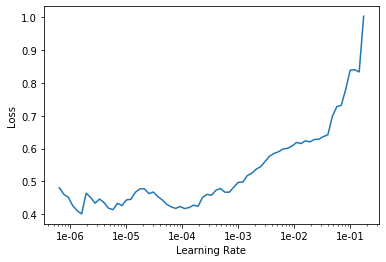

In [16]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,kappa_score,time
0,0.426764,0.410557,0.165468,0.834532,0.666854,42:35
1,0.426496,0.414391,0.168908,0.831092,0.660010,42:33
2,0.406207,0.411626,0.169221,0.830779,0.658984,42:35
3,0.393438,0.411728,0.165468,0.834532,0.667662,42:36
4,0.423945,0.412654,0.168908,0.831092,0.660797,42:34
5,0.391423,0.410013,0.166093,0.833907,0.665667,42:20
6,0.439453,0.406143,0.169534,0.830466,0.658879,42:37
7,0.429087,0.407325,0.167657,0.832343,0.662928,42:36
8,0.377190,0.412025,0.169534,0.830466,0.658640,42:36
9,0.425006,0.419454,0.172975,0.827025,0.651081,42:37


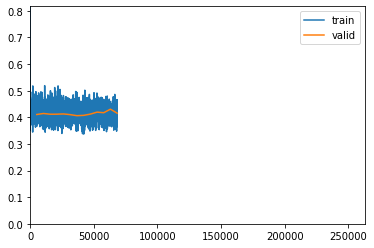

Better model found at epoch 0 with val_loss value: 0.4105570912361145.
Better model found at epoch 5 with val_loss value: 0.41001302003860474.
Better model found at epoch 6 with val_loss value: 0.40614262223243713.
Epoch 12: early stopping


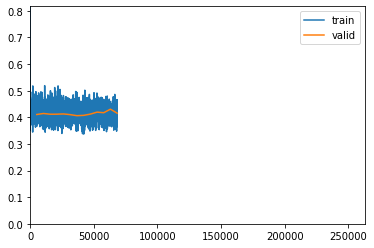

In [17]:
lr=1e-6

learn.fit_one_cycle(50 ,max_lr=slice(lr/100 , lr),callbacks=[ShowGraph(learn),EarlyStoppingCallback(learn, monitor='val_loss', mode='min', min_delta=0.0001, patience=5),SaveModelCallback(learn ,monitor='val_loss',  mode='min')])

In [18]:
learn.save('densenet161-last-stage-2-n2')

In [12]:
learn.load('densenet161-last-stage-2-n2');

In [13]:
learn.purge()
learn.unfreeze()

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


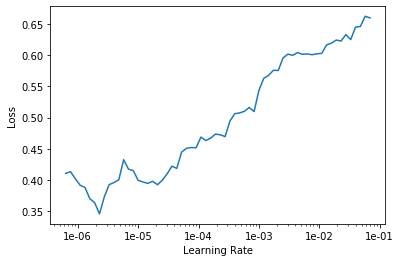

In [15]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,kappa_score,time
0,0.414141,0.412270,0.168283,0.831717,0.661342,50:15
1,0.447491,0.421555,0.174539,0.825461,0.647516,50:34
2,0.448168,0.407847,0.165780,0.834220,0.666593,50:35
3,0.404473,0.416680,0.172036,0.827964,0.653058,50:38
4,0.429163,0.415645,0.171098,0.828902,0.654960,50:37
5,0.431563,0.427989,0.176103,0.823897,0.644213,50:28
6,0.427577,0.411560,0.167344,0.832656,0.663910,50:24
7,0.426554,0.412053,0.165780,0.834220,0.666252,50:27


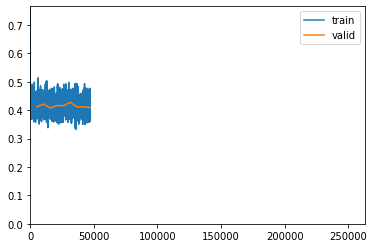

Better model found at epoch 0 with val_loss value: 0.41227027773857117.
Better model found at epoch 2 with val_loss value: 0.40784651041030884.
Epoch 8: early stopping


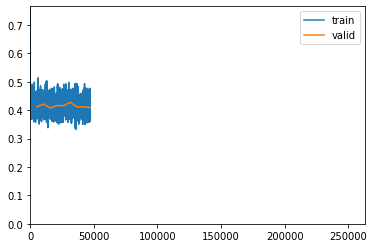

In [16]:
lr=1e-6

learn.fit_one_cycle(50 ,max_lr=slice(lr/100 , lr),callbacks=[ShowGraph(learn),EarlyStoppingCallback(learn, monitor='val_loss', mode='min', min_delta=0.0001, patience=5),SaveModelCallback(learn ,monitor='val_loss',  mode='min')])

In [17]:
learn.save('densenet161-last-stage-3-n2')

#### Results by image

In [27]:
learn.load('densenet161-last-stage-3-n2');

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

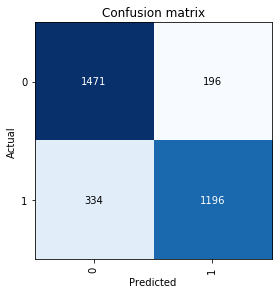

In [29]:
# first interpretation
interp.plot_confusion_matrix()

In [30]:
interp.most_confused(min_val=2)

[('1', '0', 334), ('0', '1', 196)]

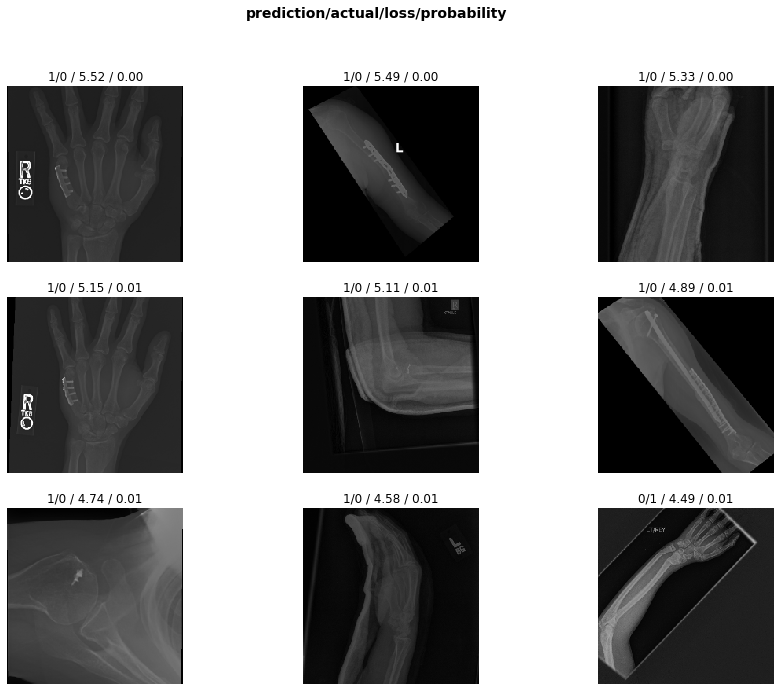

In [32]:
interp.plot_top_losses(9,heatmap=False, figsize=(15,11))

#### Accuracy and kappa by study

Source for kappa score calculation: [Cohen's kappa in plain English](https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english)

In [33]:
learn.load('densenet161-last-stage-3-n2');

In [34]:
for img_url in data.valid_ds.x.items:
    print(img_url)
    break

/home/hussamwahba/.fastai/data/MURA-v1.1/data2/valid/1/SHOULDER_patient11300_study2_positive_image2.png


In [35]:
# predictions on validation
preds_val, y_val = learn.get_preds()

In [36]:
# file to save 
file = path / 'results_densenet161_224.csv'

In [37]:
%%time
probs_of_images_by_studies = dict()
num_img_by_studies = dict()
labels_of_studies = dict()
num_studies_by_label = dict()
list_studies_by_label = dict()
idx_by_studies = dict()
results_by_label = dict()
acc_by_label = OrderedDict()
kappa_score = OrderedDict()

pat_label = re.compile(r'/([^/]+)_patient[^/]+.png$')
pat_study = re.compile(r'/([^/]+)_[^_]+.png$')

for idx, src in enumerate(data.valid_ds.x.items):
    # get label name
    label = pat_label.search(str(src))
    label = label.group(1) 
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1) 
    # sum probabilities by study
    if study in probs_of_images_by_studies:
        probs_of_images_by_studies[study] += preds_val[idx,:].clone()
        num_img_by_studies[study] += 1
        idx_by_studies[study].append(idx)
    else:
        probs_of_images_by_studies[study] = preds_val[idx,:].clone()
        num_img_by_studies[study] = 1
        labels_of_studies[study] = label
        idx_by_studies[study] = [idx]
        
for m in mura:
    num_studies_by_label[m] = sum([1 for k,v in labels_of_studies.items() if v.lower() == m])
    list_studies_by_label[m] = [k for k,v in labels_of_studies.items() if v.lower() == m]
    
for m in mura:
    list_studies = list_studies_by_label[m]
    TN, FP, TP, FN = 0, 0, 0, 0
    for study in list_studies:
        preds_val2 = preds_val.clone()
        idxs = idx_by_studies[study]
        preds = preds_val2[idxs]
        y_hat = np.argmax(preds, axis=1)
        y = y_val[idxs]
        if 'negative' in study:
            TN += sum(y_hat.numpy() == y.numpy())
            FP += sum(y_hat.numpy() != y.numpy())
        else:
            TP += sum(y_hat.numpy() == y.numpy())
            FN += sum(y_hat.numpy() != y.numpy())
    results_by_label[m] = [TN, FP, TP, FN]
    # accuracy
    acc_by_label[m] = (TN + TP) / (TN+FP+FN+TP)
    # kappa
    ground_truth_neg = TN+FN
    ground_truth_pos = FP+TP
    classifier_neg = TN+FP
    classifier_pos = FN+TP
    total = classifier_neg + classifier_pos
    observed_accuracy = (TN + TP) / total
    expected_accuracy = ((ground_truth_neg * classifier_neg / total) + (ground_truth_pos * classifier_pos / total)) / total
    kappa_score[m] = (observed_accuracy - expected_accuracy) / (1 - expected_accuracy)

# overall accuracy and kappa
[TN, FP, TP, FN] = [0,0,0,0]
for m in mura:
    results = results_by_label[m]
    TN += results[0]
    FP += results[1]
    TP += results[2]
    FN += results[3]
# overall accuracy 
acc_by_label['overall'] = (TN + TP) / (TN+FP+FN+TP)
# overall kappa
ground_truth_neg = TN+FN
ground_truth_pos = FP+TP
classifier_neg = TN+FP
classifier_pos = FN+TP
total = classifier_neg + classifier_pos
observed_accuracy = (TN + TP) / total
expected_accuracy = ((ground_truth_neg * classifier_neg / total) + (ground_truth_pos * classifier_pos / total)) / total
kappa_score['overall'] = (observed_accuracy - expected_accuracy) / (1 - expected_accuracy)

# Create DataFrame
for k, v in acc_by_label.items():
    acc_by_label[k] = round(v, 3)
for k, v in kappa_score.items():
    kappa_score[k] = round(v, 3)
    
df = pd.DataFrame([acc_by_label, kappa_score], index =['accuracy', 'kappa']) 
df.name = 'Results on validation at a study level'
df = df.transpose()

# save df
df.to_csv(file,header=True)

print(df)

          accuracy  kappa
elbow        0.888  0.776
finger       0.796  0.593
forearm      0.827  0.655
hand         0.817  0.613
humerus      0.851  0.702
shoulder     0.805  0.609
wrist        0.856  0.706
overall      0.834  0.667
CPU times: user 192 ms, sys: 0 ns, total: 192 ms
Wall time: 192 ms


### Check overall accuracy and kappa

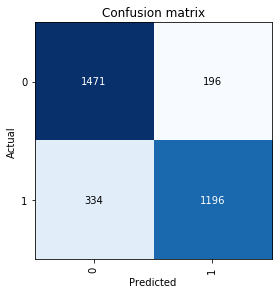

In [38]:
# first interpretation
interp.plot_confusion_matrix()

In [39]:
cm = interp.confusion_matrix()

TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TP = cm[1,1]

In [40]:
# accuracy
acc = (TN + TP) / (TN+FP+FN+TP)

# kappa
ground_truth_neg = TN+FN
ground_truth_pos = FP+TP
classifier_neg = TN+FP
classifier_pos = FN+TP
total = classifier_neg + classifier_pos
observed_accuracy = (TN + TP) / total
expected_accuracy = ((ground_truth_neg * classifier_neg / total) + (ground_truth_pos * classifier_pos / total)) / total
kappa_score = (observed_accuracy - expected_accuracy) / (1 - expected_accuracy)

round(acc,3), round(kappa_score,3)

(0.834, 0.667)